In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib.ticker import LogLocator, NullFormatter
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from matplotlib import rcParams
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


h = 0.67
ρ_c0= 1.9e-26 * (h**2) #kgm^-3  
Ω_r0 = 9.4e-5
Ω_m0 = 0.32
ρ_r0 = Ω_r0 * ρ_c0
ρ_m0 = Ω_m0 * ρ_c0
H_0 = np.sqrt((8 * π * G * ρ_c0)/3)





# Define event functions to detect turnaround points
def event_y_max(t, y, *args):
    return y[1]  # Detect velocity = 0 (turnaround)
event_y_max.terminal = False  
event_y_max.direction = -1  # Detect peak (expansion slowing down)



def event_y_min(t, y, *args):
    return y[1]  # Detect velocity = 0
event_y_min.terminal = True   # Stop at turnaround
event_y_min.direction = 1     # Detect minimum (collapse starts)



#def a(t): # as per RD
    #return np.sqrt(2 * H_0 * t)
    
#def rho_DM(t):
    #return 0.85 * ρ_m0 * (a(t)**-3)  

    
def a(t):
    return  np.sqrt(2 * t * (a_eq**2))  *  ((3/(4 * π * G * ρ_eq))**(-1/2))


def V_shell(r_outer, r_inner):
    return (4 * π / 3) * (r_outer**3 - r_inner**3)


def rho_DM(t):
    return (ρ_eq/2) * ((a(t)/a_eq)**(-3))  


def mfdm_shell_initial(r, t):
    return rho_DM(t) * ((4/3) * np.pi * (r**3)) 



def V_shell(r_outer, r_inner):
    #delta_r = r_outer - r_inner
    #if np.isclose(delta_r, 0, rtol=1e-12, atol=1e-20):
       # return 1e-10  
    #else:
    return (4/3) * np.pi * (r_outer**3 - r_inner**3)


def shells_mass(ri_arr, N, initial_density):
    m_shell = np.zeros(N)
    for j in range(N):
        if j == 0:
            m_shell[j] = initial_density * V_shell(ri_arr[j], 0)
        else:
            m_shell[j] = initial_density * V_shell(ri_arr[j], ri_arr[j-1])
    return m_shell


def shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt):
    rho_shell = np.zeros(N)
    for j in range(N - 1):
        if j == 0:
            delta_V = V_shell(r_sol[1, i], 0)
            rho_shell[j] = (delta_M_arr[1] + delta_M_arr[0]) / delta_V if delta_V > 0 else rho_sol[j, i-1]
        else:
            delta_Vj = V_shell(r_sol[j, i], r_sol[j-1, i])
            delta_Vj1 = V_shell(r_sol[j+1, i], r_sol[j, i])
            delta_Vsum = delta_Vj + delta_Vj1
            rho_shell[j] = (delta_M_arr[j] + delta_M_arr[j+1]) / delta_Vsum if delta_Vsum > 0 else rho_sol[j, i-1]

    delta_V_last = V_shell(r_sol[-1, i], r_sol[-2, i])
    rho_shell[-1] = delta_M_arr[-1] / delta_V_last if delta_V_last > 0 else rho_sol[-1, i-1]

    return rho_shell




def qp_force_numerical(rho_var, r):
    rho_var = np.clip(rho_var, 1e-20, np.inf)
    grad_rho = np.gradient(rho_var, r, edge_order=2)
    laplacian_rho = (1/(r**2)) * np.gradient((r**2) * grad_rho, r, edge_order=2)
    qp_term = (laplacian_rho/rho_var) - ((1/2) * (grad_rho**2) / (rho_var**2))
    return (1/4) * np.gradient(qp_term, r, edge_order=2)




def shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction):
    rta_mask = [[] for _ in range(N)]
    tta_mask = [[] for _ in range(N)]
    r_freeze_arr = np.full(N, np.nan) 
    shells_crossing = False
    
    for i in range(len(t_arr)):
        t = t_arr[i]
        dt_i = dt[i]
        rho_arr = shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt)
        rho_sol[:, i] = rho_arr

        QP_arr = np.zeros(N)
        if QP:
            QP_arr = qp_force_numerical(rho_arr, r_sol[:, i])

        for j in range(N):
            if not mask_active[j]:
                continue

            dv_dt = 0
            if Hubble:
                dv_dt += -r_sol[j, i] / (4 * (t ** 2))
            if gravity:
                dv_dt += -1 / (r_sol[j, i] ** 2) if r_sol[j, i] > 0 else 0
            if QP:
                dv_dt += QP_arr[j]

            v_next = v_sol[j, i] + dv_dt * dt_i
            r_next = r_sol[j, i] + v_sol[j, i] * dt_i

            
            if not turnaround_detected[j] and 1 <= i < len(t_arr) - 1:
                if not turnaround_detected[j] and v_sol[j, i] > 0 and v_next < 0:
                    turnaround_detected[j] = True
                    t_ta_arr[j] = t_arr[i + 1]
                    r_ta_arr[j] = r_next
                    r_freeze_arr[j] = freeze_fraction * r_ta_arr[j]

           
            if turnaround_detected[j] and r_next <= r_freeze_arr[j]:
                r_sol[j, i + 1:] = r_freeze_arr[j]
                v_sol[j, i + 1:] = 0
                mask_active[j] = False
                cutoff_index[j] = i + 1
                continue

           
            if i < len(t_arr) - 1:
                r_sol[j, i + 1] = r_next
                v_sol[j, i + 1] = v_next
             
           
        
    if QP:
                    
        for j in range(N - 1):
            if r_sol[j, i] > r_sol[j + 1, i]:
                shells_crossing = True
                print(f"Shells crossed each-other at time = {t_arr[i]:.3e}, y_{j} = {r_sol[j, i]:.3e}, y_{j+1} = {r_sol[j+1, i]:.3e} (shell {j} overtook shell {j+1})")

        if not shells_crossing:
            print("No shells crossings is detected.")


    return r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask


No shells crossings is detected.


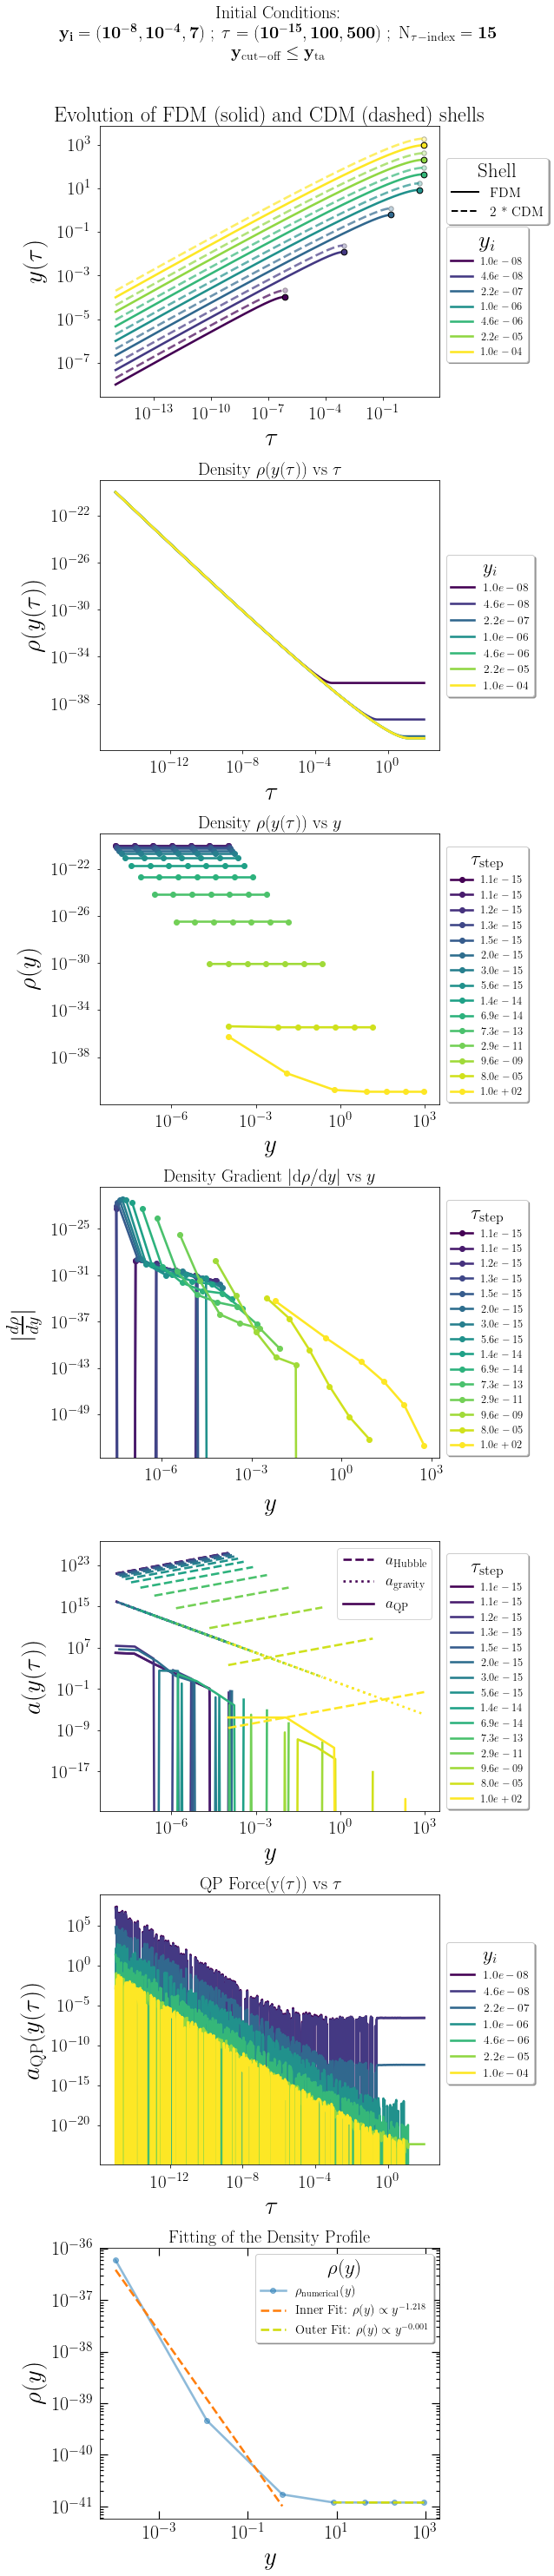

 Fitted slope (inner core):    \rho(y) \propto y^{-1.218}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.001}


In [2]:



# for 7 FDM shells

t_i, t_f = 1e-15, 1e2
N = 7
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])


freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)
#time_indices = [0, 2499, 4999, 7499, 9999]



fig, axs = plt.subplots(7, 1, figsize=(9, 42), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)





colors_shell = cm.viridis(np.linspace(0, 1, N))

for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], 2*r_sol_no_qp[j, :cutoff], color=colors_shell[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], 2*r_ta_arr_no_qp[j], marker='o', s=30, color=colors_shell[j], edgecolor='k', alpha=0.3)
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors_shell[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors_shell[j], edgecolor='k', zorder=5)
    

ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

handles, labels = ax.get_legend_handles_labels()
legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                          loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                          facecolor='white', fontsize=25)

legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
                Line2D([0], [0], color='k', linestyle='--', lw=2)]
ax.legend(legend_lines, ['FDM', '2 * CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
          shadow=True, title='Shell', title_fontsize=23,
          facecolor='white', fontsize=20)
ax.add_artist(legend_shells)





#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for j in range(N):  
    rho_shell_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        rho_shell_arr.append(rho_arr[j])
    ax.loglog(t_arr,  rho_shell_arr, color = colors_shell[j], label=r'$ {0:.1e}$'.format(ri_arr[j]))

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
ax.legend(prop = {'size':13.5}, loc = (1.02, 0.2),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 25)
ax.set_title(r'Density $\rho(y(\tau))$ vs $\tau$', fontsize=20)





#----------------------------------------------------------
#Density vs y at different time steps




ax = axs[2]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
            facecolor = 'white',fontsize = 23)
#ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 






#----------------------------------------------------------
#density gradient at different time steps


ax = axs[3]
for i, idx in enumerate(time_indices):
    r_arr = r_sol[:, idx]
    rho_arr = rho_sol[:, idx]
    drho_dr = np.diff(rho_arr) / np.diff(r_arr)
    r_mid = 0.5 * (r_arr[:-1] + r_arr[1:])
    ax.loglog(r_mid, np.abs(drho_dr), marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.set_ylabel(r'$|\frac{d\rho}{dy}|$', fontsize=29, labelpad=11)
ax.set_xlabel(r'$y$', fontsize=29, labelpad=11)
ax.set_title(r'Density Gradient $|\mathrm{d}\rho/\mathrm{d}y|$ vs $y$', fontsize=20)
ax.legend(prop={'size':12.5}, loc=(1.02, 0.01), shadow=True, title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=23)
ax.xaxis.set_tick_params(labelsize=21)
ax.yaxis.set_tick_params(labelsize=21)




#-------------------------------------------------------


# QP force vs y (for all the shells ) at different time steps in range of 
# time = (t_i, t_f, t_step)


ax = axs[4]
for k, idx in enumerate(time_indices):
    rho_arr = rho_sol[:, idx]
    r_arr = r_sol[:, idx]
    qp_val = qp_force_numerical(rho_arr, r_arr)
    a_hubble = np.abs(-r_arr / (4 * (t_arr[idx]**2)))
    a_gravity = np.abs(-1 / (r_arr**2))
    
    
    ax.loglog(r_arr, a_hubble, linestyle='--', color=colors1[k])
    ax.loglog(r_arr, a_gravity, linestyle=':', color=colors1[k])
    ax.loglog(r_arr, qp_val, color=colors1[k], label=f'${t_arr[idx]:.1e}$')
    
    #for shell_index in range(N-1):
        #shell_color = colors_shell[shell_index % len(colors_shell)]
        #ax.scatter(r_arr[shell_index], qp_val[shell_index],
                  # edgecolor='black', s=70, zorder=5, color= shell_color)

            
            
lines = ax.get_lines()
legend1 = ax.legend([lines[i] for i in [0, 1, 2]], ['$a_{\mathrm{Hubble}}$', 
                '$a_{\mathrm{gravity}}$', '$a_{\mathrm{QP}}$'], 
          prop={'size': 17.5}, loc='upper right')
ax.add_artist(legend1)
ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
ax.set_xlabel(r'$y$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$a(y(\tau))$', fontsize= 29, labelpad = 6)
ax.legend(prop={'size': 12.5}, loc = (1.02, 0.01), shadow=True,
          title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=13.2)




#-------------------------------------------------------------



#QP force for each shell vs time
ax = axs[5]
for j in range(N):  
    qp_force_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        qp_value = qp_force_numerical(rho_arr, r_arr)
        qp_force_arr.append(qp_value[j])
    ax.loglog(t_arr,  qp_force_arr, color = colors_shell[j], label=r'$ {0:.1e}$'.format(ri_arr[j]) )

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$a_{\mathrm{QP}}(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 


ax.legend(prop = {'size':13.5},loc = (1.02, 0.3),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 25)


#ax.set_title(r'QP force for each shell vs time $\tau$', fontsize= 28)
ax.set_title(r'QP Force(y($\tau$)) vs $\tau$ ', fontsize=20)







###################################
# Fitting the density profile
ax = axs[6]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 4

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------


plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 7)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15 }$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N7_t15.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')


No shells crossings is detected.


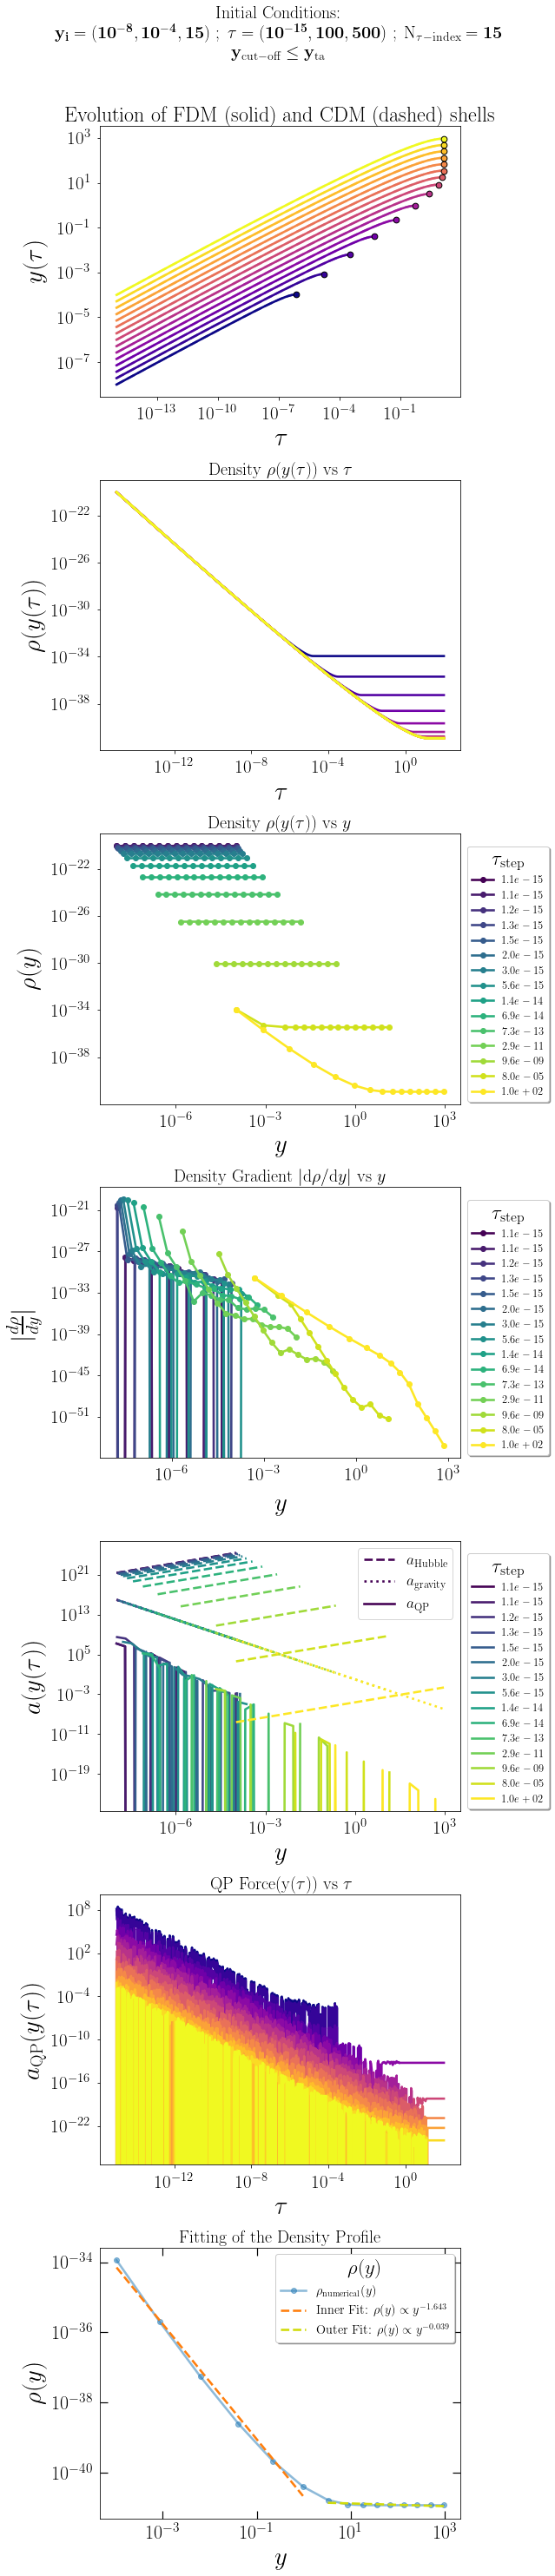

 Fitted slope (inner core):    \rho(y) \propto y^{-1.643}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.039}


In [3]:
# for 15 FDM shells

t_i, t_f = 1e-15, 1e2
N = 15
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction = 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)
#time_indices = [0, 2499, 4999, 7499, 9999]



fig, axs = plt.subplots(7, 1, figsize=(9, 42), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for j in range(N):  
    rho_shell_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        rho_shell_arr.append(rho_arr[j])
    ax.loglog(t_arr,  rho_shell_arr, color = colors2[j], label=r'$ {0:.1e}$'.format(ri_arr[j]))

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
#ax.legend(prop = {'size':12.5}, loc = (1.02, 0.01),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
          # facecolor = 'white',fontsize = 25)
ax.set_title(r'Density $\rho(y(\tau))$ vs $\tau$', fontsize=20)





#----------------------------------------------------------
#Density vs y at different time steps




ax = axs[2]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
            facecolor = 'white',fontsize = 23)
#ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 






#----------------------------------------------------------
#density gradient at different time steps


ax = axs[3]
for i, idx in enumerate(time_indices):
    r_arr = r_sol[:, idx]
    rho_arr = rho_sol[:, idx]
    drho_dr = np.diff(rho_arr) / np.diff(r_arr)
    r_mid = 0.5 * (r_arr[:-1] + r_arr[1:])
    ax.loglog(r_mid, np.abs(drho_dr), marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.set_ylabel(r'$|\frac{d\rho}{dy}|$', fontsize=29, labelpad=11)
ax.set_xlabel(r'$y$', fontsize=29, labelpad=11)
ax.set_title(r'Density Gradient $|\mathrm{d}\rho/\mathrm{d}y|$ vs $y$', fontsize=20)
ax.legend(prop={'size':12.5}, loc=(1.02, 0.01), shadow=True, title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=23)
ax.xaxis.set_tick_params(labelsize=21)
ax.yaxis.set_tick_params(labelsize=21)




#-------------------------------------------------------


# QP force vs y (for all the shells ) at different time steps in range of 
# time = (t_i, t_f, t_step)


ax = axs[4]
for k, idx in enumerate(time_indices):
    rho_arr = rho_sol[:, idx]
    r_arr = r_sol[:, idx]
    qp_val = qp_force_numerical(rho_arr, r_arr)
    a_hubble = np.abs(-r_arr / (4 * (t_arr[idx]**2)))
    a_gravity = np.abs(-1 / (r_arr**2))
    
    
    ax.loglog(r_arr, a_hubble, linestyle='--', color=colors1[k])
    ax.loglog(r_arr, a_gravity, linestyle=':', color=colors1[k])
    ax.loglog(r_arr, qp_val, color=colors1[k], label=f'${t_arr[idx]:.1e}$')
    
    #for shell_index in range(N-1):
        #shell_color = colors_shell[shell_index % len(colors_shell)]
        #ax.scatter(r_arr[shell_index], qp_val[shell_index],
                  # edgecolor='black', s=70, zorder=5, color= shell_color)

            
            
lines = ax.get_lines()
legend1 = ax.legend([lines[i] for i in [0, 1, 2]], ['$a_{\mathrm{Hubble}}$', 
                '$a_{\mathrm{gravity}}$', '$a_{\mathrm{QP}}$'], 
          prop={'size': 17.5}, loc='upper right')
ax.add_artist(legend1)
ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
ax.set_xlabel(r'$y$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$a(y(\tau))$', fontsize= 29, labelpad = 6)
ax.legend(prop={'size': 12.5}, loc = (1.02, 0.01), shadow=True,
          title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=13.2)




#-------------------------------------------------------------



#QP force for each shell vs time
ax = axs[5]
for j in range(N):  
    qp_force_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        qp_value = qp_force_numerical(rho_arr, r_arr)
        qp_force_arr.append(qp_value[j])
    ax.loglog(t_arr,  qp_force_arr, color = colors2[j], label=r'$ {0:.1e}$'.format(ri_arr[j]) )

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$a_{\mathrm{QP}}(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 


#ax.legend(prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
          # facecolor = 'white',fontsize = 25)


#ax.set_title(r'QP force for each shell vs time $\tau$', fontsize= 28)
ax.set_title(r'QP Force(y($\tau$)) vs $\tau$ ', fontsize=20)



###################################
# Fitting the density profile
ax = axs[6]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 6
outer_N = 9

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

#---------------------------------------------------------------------


plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 15)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15 }$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N15_t15.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')


No shells crossings is detected.


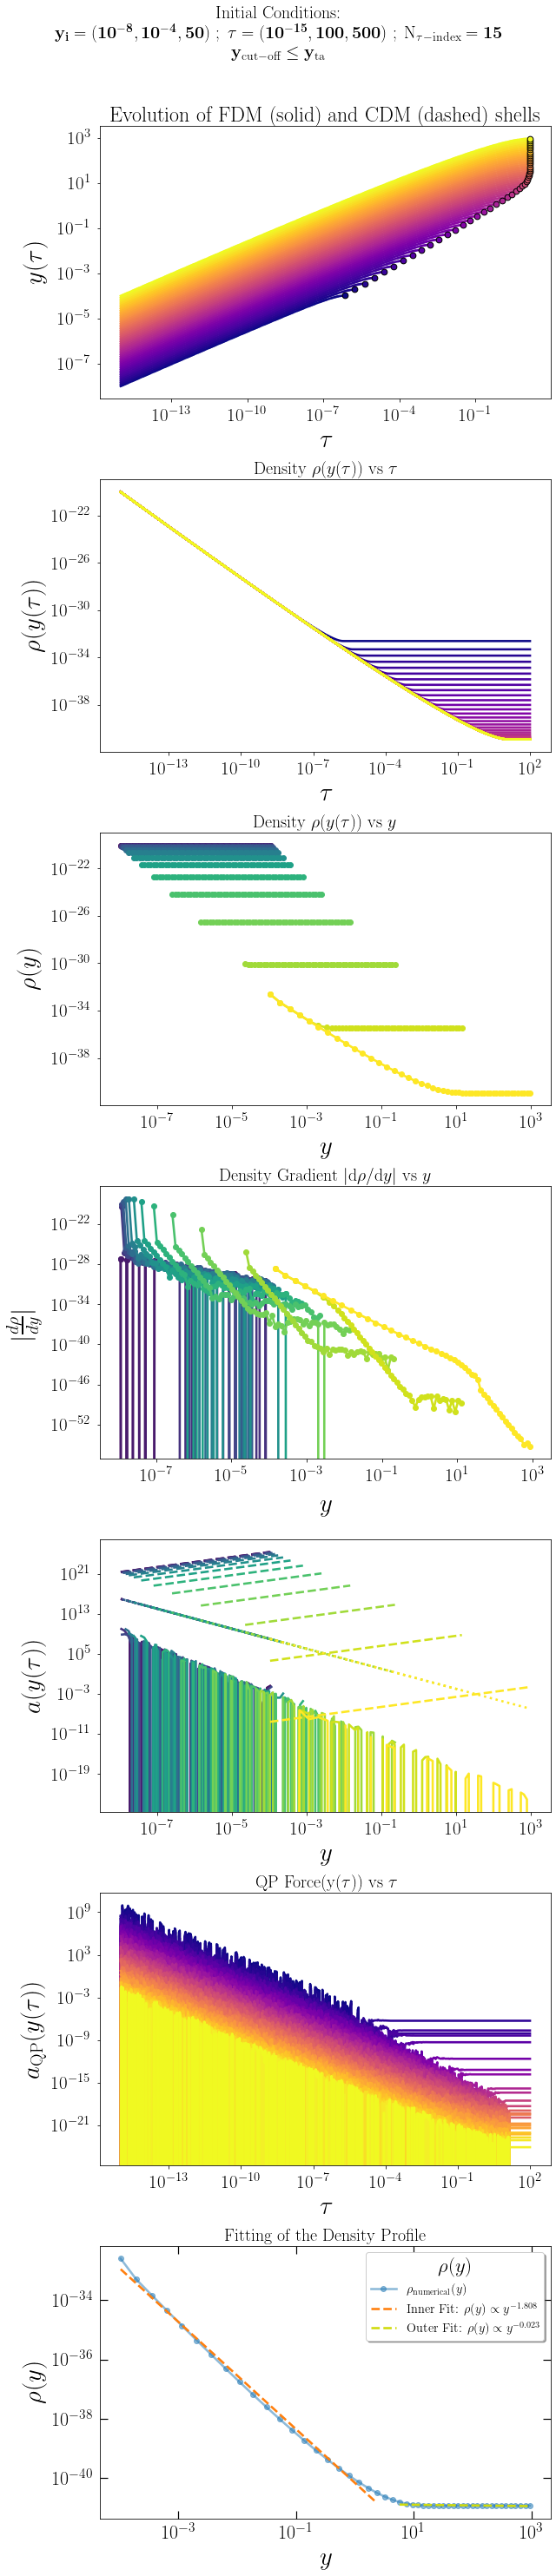

 Fitted slope (inner core):    \rho(y) \propto y^{-1.808}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.023}


In [4]:
# for 50 FDM shells

t_i, t_f = 1e-15, 1e2
N = 50
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)
#time_indices = [0, 2499, 4999, 7499, 9999]



fig, axs = plt.subplots(7, 1, figsize=(9, 42), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for j in range(N):  
    rho_shell_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        rho_shell_arr.append(rho_arr[j])
    ax.loglog(t_arr,  rho_shell_arr, color = colors2[j], label=r'$ {0:.1e}$'.format(ri_arr[j]))

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
#ax.legend(prop = {'size':12.5}, loc = (1.02, 0.01),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
          # facecolor = 'white',fontsize = 25)
ax.set_title(r'Density $\rho(y(\tau))$ vs $\tau$', fontsize=20)





#----------------------------------------------------------
#Density vs y at different time steps




ax = axs[2]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
#ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
          #  facecolor = 'white',fontsize = 23)
#ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 






#----------------------------------------------------------
#density gradient at different time steps


ax = axs[3]
for i, idx in enumerate(time_indices):
    r_arr = r_sol[:, idx]
    rho_arr = rho_sol[:, idx]
    drho_dr = np.diff(rho_arr) / np.diff(r_arr)
    r_mid = 0.5 * (r_arr[:-1] + r_arr[1:])
    ax.loglog(r_mid, np.abs(drho_dr), marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.set_ylabel(r'$|\frac{d\rho}{dy}|$', fontsize=29, labelpad=11)
ax.set_xlabel(r'$y$', fontsize=29, labelpad=11)
ax.set_title(r'Density Gradient $|\mathrm{d}\rho/\mathrm{d}y|$ vs $y$', fontsize=20)
#ax.legend(prop={'size':12.5}, loc=(1.02, 0.01), shadow=True, title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=23)
ax.xaxis.set_tick_params(labelsize=21)
ax.yaxis.set_tick_params(labelsize=21)




#-------------------------------------------------------


# QP force vs y (for all the shells ) at different time steps in range of 
# time = (t_i, t_f, t_step)


ax = axs[4]
for k, idx in enumerate(time_indices):
    rho_arr = rho_sol[:, idx]
    r_arr = r_sol[:, idx]
    qp_val = qp_force_numerical(rho_arr, r_arr)
    a_hubble = np.abs(-r_arr / (4 * (t_arr[idx]**2)))
    a_gravity = np.abs(-1 / (r_arr**2))
    
    
    ax.loglog(r_arr, a_hubble, linestyle='--', color=colors1[k])
    ax.loglog(r_arr, a_gravity, linestyle=':', color=colors1[k])
    ax.loglog(r_arr, qp_val, color=colors1[k], label=f'${t_arr[idx]:.1e}$')
    
    #for shell_index in range(N-1):
        #shell_color = colors_shell[shell_index % len(colors_shell)]
        #ax.scatter(r_arr[shell_index], qp_val[shell_index],
                  # edgecolor='black', s=70, zorder=5, color= shell_color)

            
            
#lines = ax.get_lines()
#legend1 = ax.legend([lines[i] for i in [0, 1, 2]], ['$a_{\mathrm{Hubble}}$', 
            #    '$a_{\mathrm{gravity}}$', '$a_{\mathrm{QP}}$'], 
         # prop={'size': 17.5}, loc='upper right')
#ax.add_artist(legend1)
ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
ax.set_xlabel(r'$y$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$a(y(\tau))$', fontsize= 29, labelpad = 6)
#ax.legend(prop={'size': 12.5}, loc = (1.02, 0.01), shadow=True,
         # title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=13.2)




#-------------------------------------------------------------



#QP force for each shell vs time
ax = axs[5]
for j in range(N):  
    qp_force_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        qp_value = qp_force_numerical(rho_arr, r_arr)
        qp_force_arr.append(qp_value[j])
    ax.loglog(t_arr,  qp_force_arr, color = colors2[j], label=r'$ {0:.1e}$'.format(ri_arr[j]) )

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$a_{\mathrm{QP}}(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 


#ax.legend(prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
          # facecolor = 'white',fontsize = 25)


#ax.set_title(r'QP force for each shell vs time $\tau$', fontsize= 28)
ax.set_title(r'QP Force(y($\tau$)) vs $\tau$ ', fontsize=20)








###################################
# Fitting the density profile
ax = axs[6]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 21
outer_N = 27

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

#---------------------------------------------------------------------

plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 50)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15 }$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N50_t15.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')







No shells crossings is detected.


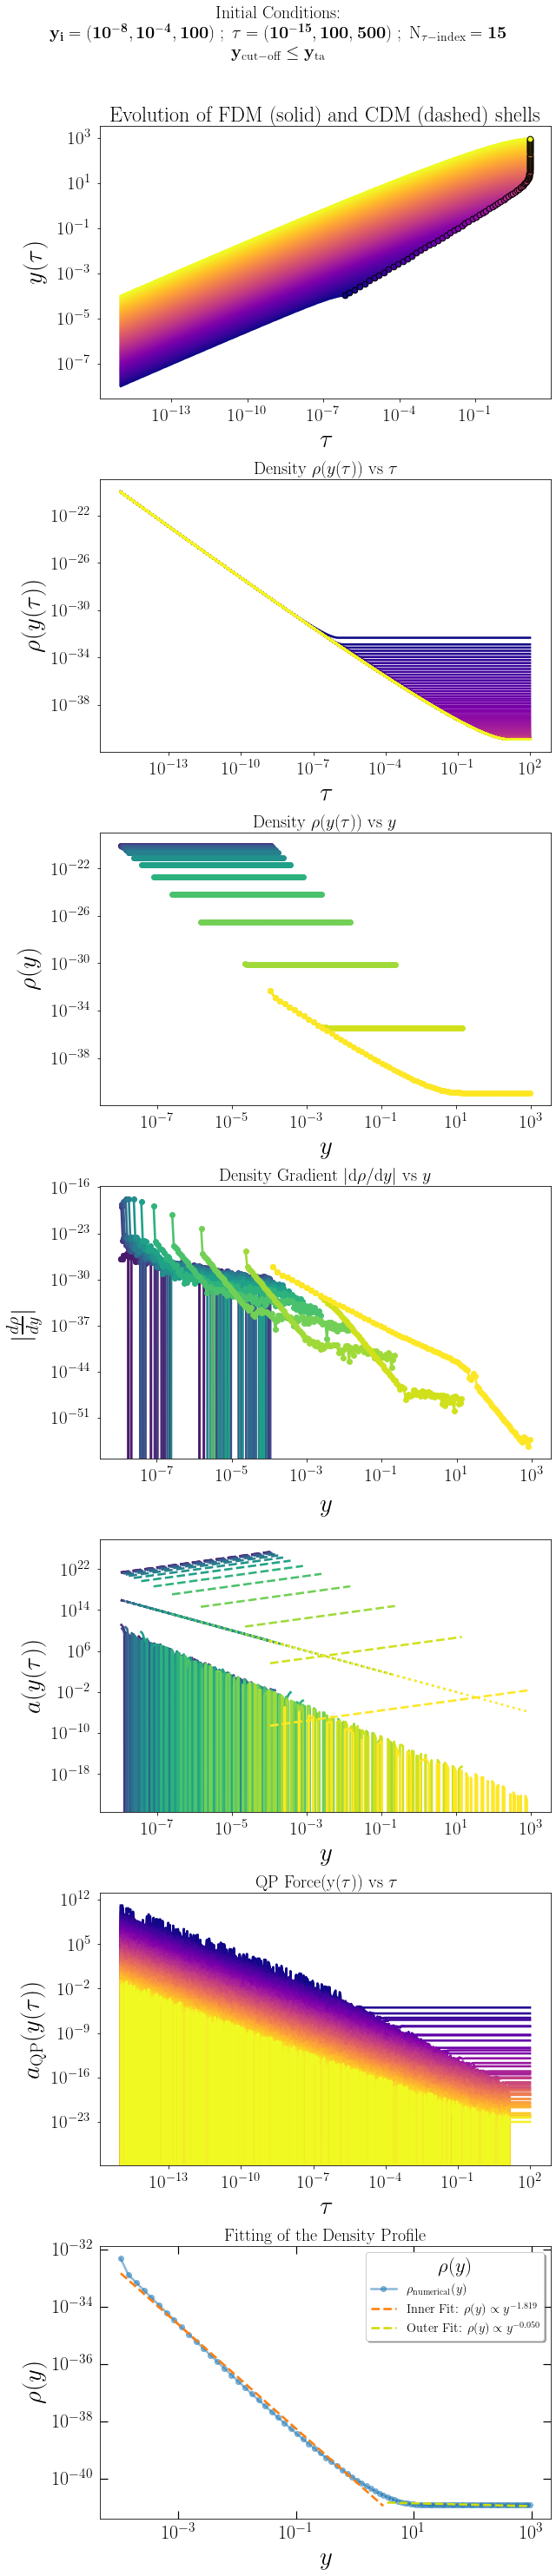

 Fitted slope (inner core):    \rho(y) \propto y^{-1.819}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.050}


In [5]:
# for 100 FDM shells

t_i, t_f = 1e-15, 1e2
N = 100
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])






freeze_fraction=1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)
#time_indices = [0, 2499, 4999, 7499, 9999]



fig, axs = plt.subplots(7, 1, figsize=(9, 42), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for j in range(N):  
    rho_shell_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        rho_shell_arr.append(rho_arr[j])
    ax.loglog(t_arr,  rho_shell_arr, color = colors2[j], label=r'$ {0:.1e}$'.format(ri_arr[j]))

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
#ax.legend(prop = {'size':12.5}, loc = (1.02, 0.01),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
          # facecolor = 'white',fontsize = 25)
ax.set_title(r'Density $\rho(y(\tau))$ vs $\tau$', fontsize=20)





#----------------------------------------------------------
#Density vs y at different time steps




ax = axs[2]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
#ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
          #  facecolor = 'white',fontsize = 23)
#ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 






#----------------------------------------------------------
#density gradient at different time steps


ax = axs[3]
for i, idx in enumerate(time_indices):
    r_arr = r_sol[:, idx]
    rho_arr = rho_sol[:, idx]
    drho_dr = np.diff(rho_arr) / np.diff(r_arr)
    r_mid = 0.5 * (r_arr[:-1] + r_arr[1:])
    ax.loglog(r_mid, np.abs(drho_dr), marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.set_ylabel(r'$|\frac{d\rho}{dy}|$', fontsize=29, labelpad=11)
ax.set_xlabel(r'$y$', fontsize=29, labelpad=11)
ax.set_title(r'Density Gradient $|\mathrm{d}\rho/\mathrm{d}y|$ vs $y$', fontsize=20)
#ax.legend(prop={'size':12.5}, loc=(1.02, 0.01), shadow=True, title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=23)
ax.xaxis.set_tick_params(labelsize=21)
ax.yaxis.set_tick_params(labelsize=21)




#-------------------------------------------------------


# QP force vs y (for all the shells ) at different time steps in range of 
# time = (t_i, t_f, t_step)


ax = axs[4]
for k, idx in enumerate(time_indices):
    rho_arr = rho_sol[:, idx]
    r_arr = r_sol[:, idx]
    qp_val = qp_force_numerical(rho_arr, r_arr)
    a_hubble = np.abs(-r_arr / (4 * (t_arr[idx]**2)))
    a_gravity = np.abs(-1 / (r_arr**2))
    
    
    ax.loglog(r_arr, a_hubble, linestyle='--', color=colors1[k])
    ax.loglog(r_arr, a_gravity, linestyle=':', color=colors1[k])
    ax.loglog(r_arr, qp_val, color=colors1[k], label=f'${t_arr[idx]:.1e}$')
    
    #for shell_index in range(N-1):
        #shell_color = colors_shell[shell_index % len(colors_shell)]
        #ax.scatter(r_arr[shell_index], qp_val[shell_index],
                  # edgecolor='black', s=70, zorder=5, color= shell_color)

            
            
#lines = ax.get_lines()
#legend1 = ax.legend([lines[i] for i in [0, 1, 2]], ['$a_{\mathrm{Hubble}}$', 
            #    '$a_{\mathrm{gravity}}$', '$a_{\mathrm{QP}}$'], 
         # prop={'size': 17.5}, loc='upper right')
#ax.add_artist(legend1)
ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
ax.set_xlabel(r'$y$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$a(y(\tau))$', fontsize= 29, labelpad = 6)
#ax.legend(prop={'size': 12.5}, loc = (1.02, 0.01), shadow=True,
         # title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=13.2)




#-------------------------------------------------------------



#QP force for each shell vs time
ax = axs[5]
for j in range(N):  
    qp_force_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        qp_value = qp_force_numerical(rho_arr, r_arr)
        qp_force_arr.append(qp_value[j])
    ax.loglog(t_arr,  qp_force_arr, color = colors2[j], label=r'$ {0:.1e}$'.format(ri_arr[j]) )

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$a_{\mathrm{QP}}(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 


#ax.legend(prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
          # facecolor = 'white',fontsize = 25)


#ax.set_title(r'QP force for each shell vs time $\tau$', fontsize= 28)
ax.set_title(r'QP Force(y($\tau$)) vs $\tau$ ', fontsize=20)








###################################
# Fitting the density profile
ax = axs[6]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 43
outer_N = 57

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

#---------------------------------------------------------------------


plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 100)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15 }$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N100_t15.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')


No shells crossings is detected.


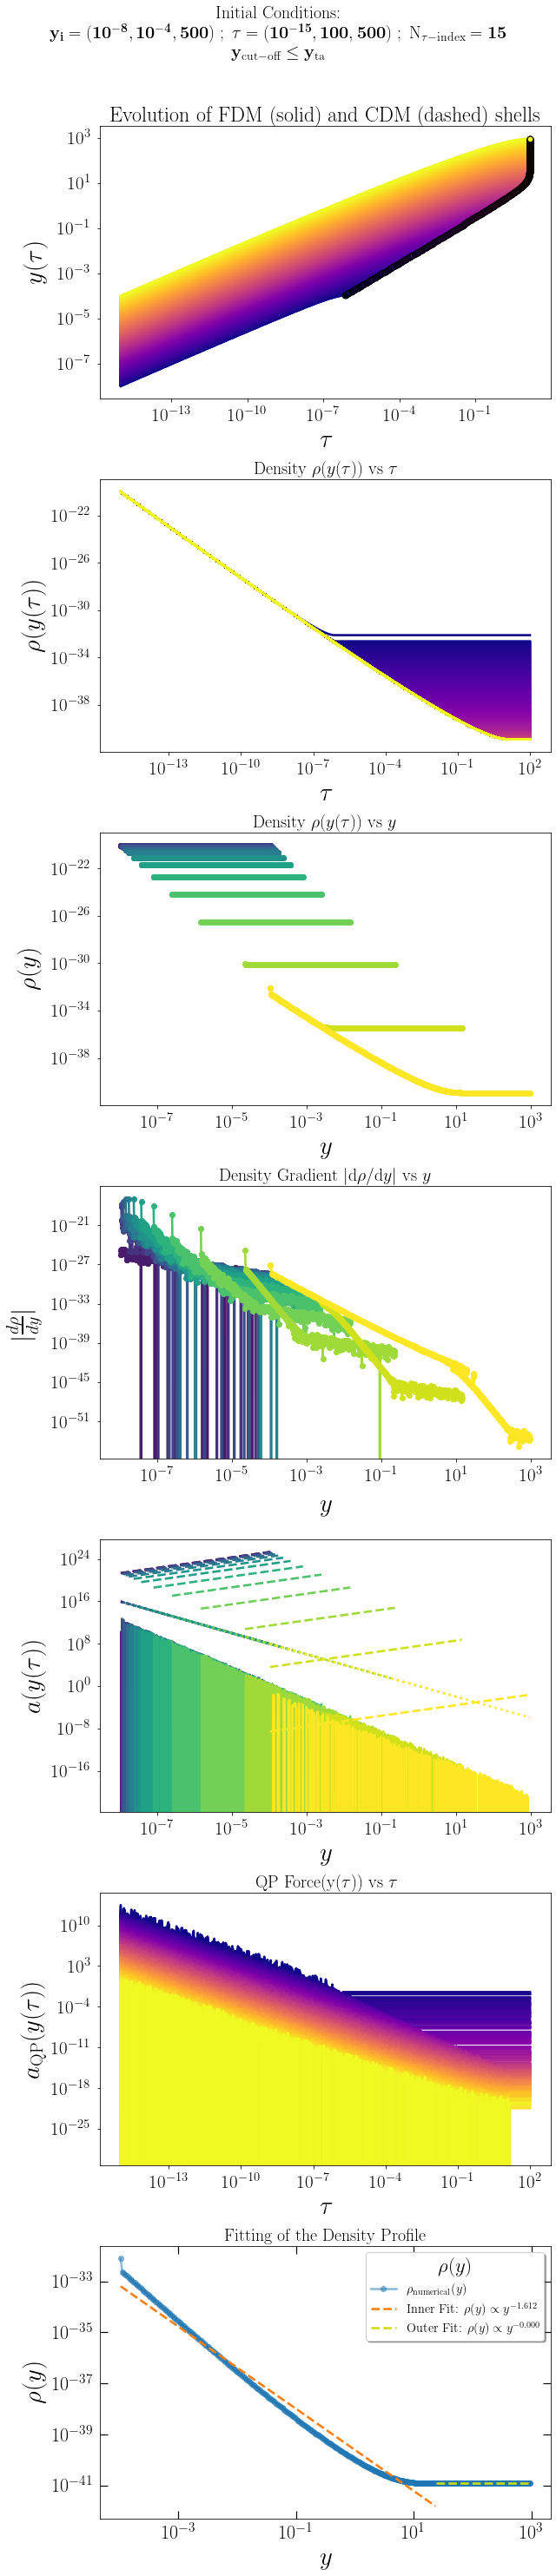

 Fitted slope (inner core):    \rho(y) \propto y^{-1.612}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [6]:
# for 500 FDM shells

t_i, t_f = 1e-15, 1e2
N = 500
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])






freeze_fraction=1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)
#time_indices = [0, 2499, 4999, 7499, 9999]



fig, axs = plt.subplots(7, 1, figsize=(9, 42), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for j in range(N):  
    rho_shell_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        rho_shell_arr.append(rho_arr[j])
    ax.loglog(t_arr,  rho_shell_arr, color = colors2[j], label=r'$ {0:.1e}$'.format(ri_arr[j]))

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
#ax.legend(prop = {'size':12.5}, loc = (1.02, 0.01),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
          # facecolor = 'white',fontsize = 25)
ax.set_title(r'Density $\rho(y(\tau))$ vs $\tau$', fontsize=20)





#----------------------------------------------------------
#Density vs y at different time steps




ax = axs[2]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
#ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
          #  facecolor = 'white',fontsize = 23)
#ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 






#----------------------------------------------------------
#density gradient at different time steps


ax = axs[3]
for i, idx in enumerate(time_indices):
    r_arr = r_sol[:, idx]
    rho_arr = rho_sol[:, idx]
    drho_dr = np.diff(rho_arr) / np.diff(r_arr)
    r_mid = 0.5 * (r_arr[:-1] + r_arr[1:])
    ax.loglog(r_mid, np.abs(drho_dr), marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.set_ylabel(r'$|\frac{d\rho}{dy}|$', fontsize=29, labelpad=11)
ax.set_xlabel(r'$y$', fontsize=29, labelpad=11)
ax.set_title(r'Density Gradient $|\mathrm{d}\rho/\mathrm{d}y|$ vs $y$', fontsize=20)
#ax.legend(prop={'size':12.5}, loc=(1.02, 0.01), shadow=True, title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=23)
ax.xaxis.set_tick_params(labelsize=21)
ax.yaxis.set_tick_params(labelsize=21)




#-------------------------------------------------------


# QP force vs y (for all the shells ) at different time steps in range of 
# time = (t_i, t_f, t_step)


ax = axs[4]
for k, idx in enumerate(time_indices):
    rho_arr = rho_sol[:, idx]
    r_arr = r_sol[:, idx]
    qp_val = qp_force_numerical(rho_arr, r_arr)
    a_hubble = np.abs(-r_arr / (4 * (t_arr[idx]**2)))
    a_gravity = np.abs(-1 / (r_arr**2))
    
    
    ax.loglog(r_arr, a_hubble, linestyle='--', color=colors1[k])
    ax.loglog(r_arr, a_gravity, linestyle=':', color=colors1[k])
    ax.loglog(r_arr, qp_val, color=colors1[k], label=f'${t_arr[idx]:.1e}$')
    
    #for shell_index in range(N-1):
        #shell_color = colors_shell[shell_index % len(colors_shell)]
        #ax.scatter(r_arr[shell_index], qp_val[shell_index],
                  # edgecolor='black', s=70, zorder=5, color= shell_color)

            
            
#lines = ax.get_lines()
#legend1 = ax.legend([lines[i] for i in [0, 1, 2]], ['$a_{\mathrm{Hubble}}$', 
            #    '$a_{\mathrm{gravity}}$', '$a_{\mathrm{QP}}$'], 
         # prop={'size': 17.5}, loc='upper right')
#ax.add_artist(legend1)
ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
ax.set_xlabel(r'$y$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$a(y(\tau))$', fontsize= 29, labelpad = 6)
#ax.legend(prop={'size': 12.5}, loc = (1.02, 0.01), shadow=True,
         # title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=13.2)




#-------------------------------------------------------------



#QP force for each shell vs time
ax = axs[5]
for j in range(N):  
    qp_force_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        qp_value = qp_force_numerical(rho_arr, r_arr)
        qp_force_arr.append(qp_value[j])
    ax.loglog(t_arr,  qp_force_arr, color = colors2[j], label=r'$ {0:.1e}$'.format(ri_arr[j]) )

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$a_{\mathrm{QP}}(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 


#ax.legend(prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
          # facecolor = 'white',fontsize = 25)


#ax.set_title(r'QP force for each shell vs time $\tau$', fontsize= 28)
ax.set_title(r'QP Force(y($\tau$)) vs $\tau$ ', fontsize=20)








###################################
# Fitting the density profile
ax = axs[6]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 300
outer_N = 200

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

#---------------------------------------------------------------------


plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 500)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15 }$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N500_t15.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')


No shells crossings is detected.


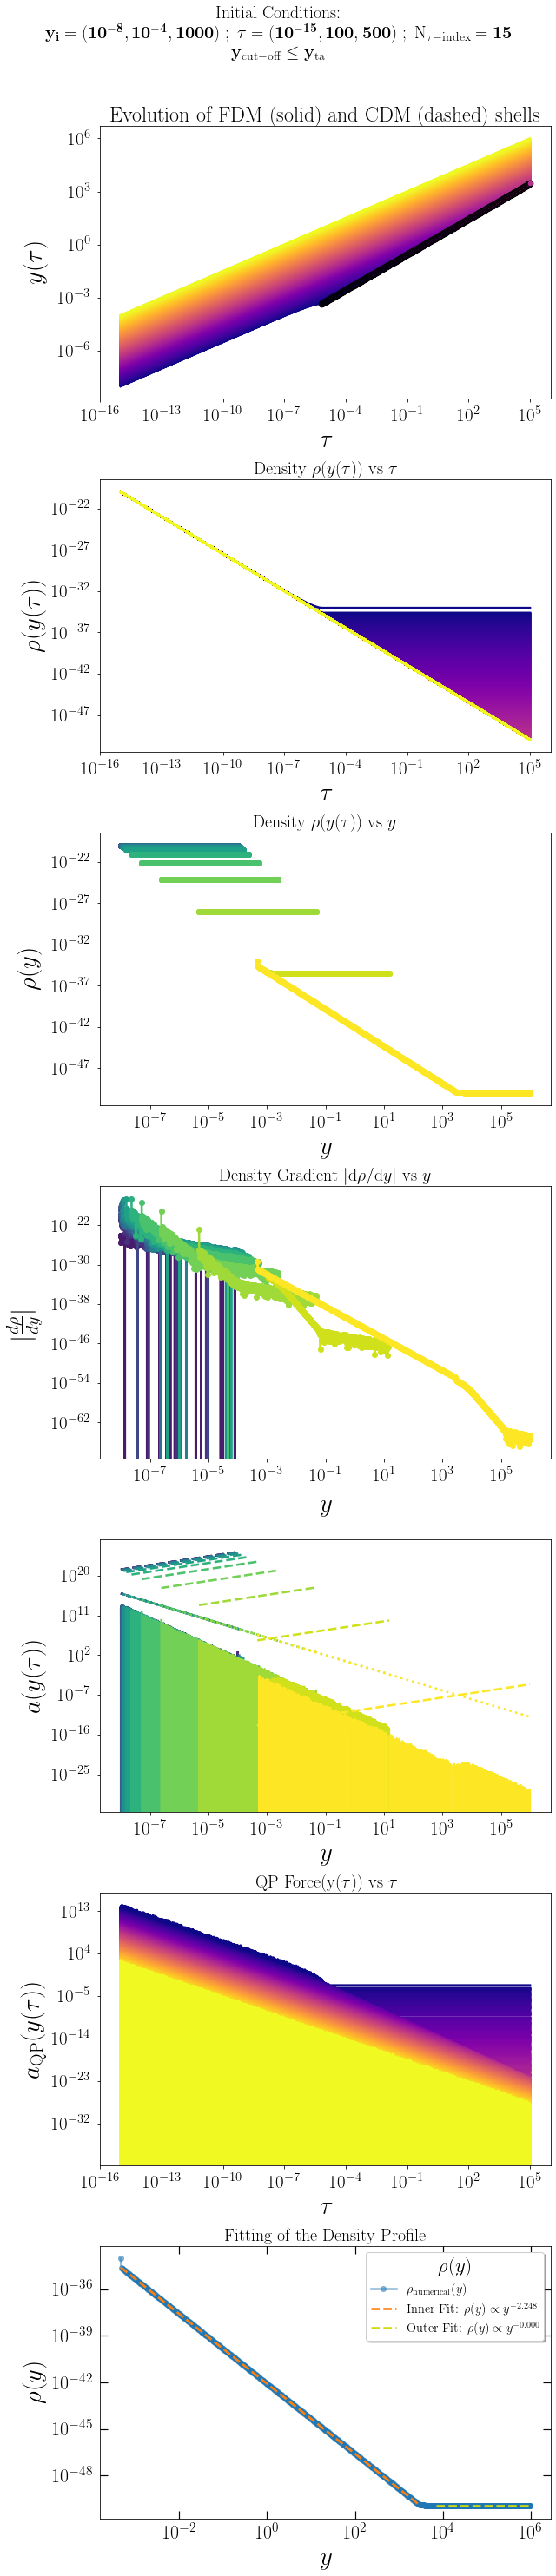

 Fitted slope (inner core):    \rho(y) \propto y^{-2.248}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [7]:


# for 1000 FDM shells

t_i, t_f = 1e-15, 1e5
N = 1000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])






freeze_fraction=1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)
#time_indices = [0, 2499, 4999, 7499, 9999]



fig, axs = plt.subplots(7, 1, figsize=(9, 42), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for j in range(N):  
    rho_shell_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        rho_shell_arr.append(rho_arr[j])
    ax.loglog(t_arr,  rho_shell_arr, color = colors2[j], label=r'$ {0:.1e}$'.format(ri_arr[j]))

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
#ax.legend(prop = {'size':12.5}, loc = (1.02, 0.01),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
          # facecolor = 'white',fontsize = 25)
ax.set_title(r'Density $\rho(y(\tau))$ vs $\tau$', fontsize=20)





#----------------------------------------------------------
#Density vs y at different time steps




ax = axs[2]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
#ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
          #  facecolor = 'white',fontsize = 23)
#ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 






#----------------------------------------------------------
#density gradient at different time steps


ax = axs[3]
for i, idx in enumerate(time_indices):
    r_arr = r_sol[:, idx]
    rho_arr = rho_sol[:, idx]
    drho_dr = np.diff(rho_arr) / np.diff(r_arr)
    r_mid = 0.5 * (r_arr[:-1] + r_arr[1:])
    ax.loglog(r_mid, np.abs(drho_dr), marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.set_ylabel(r'$|\frac{d\rho}{dy}|$', fontsize=29, labelpad=11)
ax.set_xlabel(r'$y$', fontsize=29, labelpad=11)
ax.set_title(r'Density Gradient $|\mathrm{d}\rho/\mathrm{d}y|$ vs $y$', fontsize=20)
#ax.legend(prop={'size':12.5}, loc=(1.02, 0.01), shadow=True, title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=23)
ax.xaxis.set_tick_params(labelsize=21)
ax.yaxis.set_tick_params(labelsize=21)




#-------------------------------------------------------


# QP force vs y (for all the shells ) at different time steps in range of 
# time = (t_i, t_f, t_step)


ax = axs[4]
for k, idx in enumerate(time_indices):
    rho_arr = rho_sol[:, idx]
    r_arr = r_sol[:, idx]
    qp_val = qp_force_numerical(rho_arr, r_arr)
    a_hubble = np.abs(-r_arr / (4 * (t_arr[idx]**2)))
    a_gravity = np.abs(-1 / (r_arr**2))
    
    
    ax.loglog(r_arr, a_hubble, linestyle='--', color=colors1[k])
    ax.loglog(r_arr, a_gravity, linestyle=':', color=colors1[k])
    ax.loglog(r_arr, qp_val, color=colors1[k], label=f'${t_arr[idx]:.1e}$')
    
    #for shell_index in range(N-1):
        #shell_color = colors_shell[shell_index % len(colors_shell)]
        #ax.scatter(r_arr[shell_index], qp_val[shell_index],
                  # edgecolor='black', s=70, zorder=5, color= shell_color)

            
            
#lines = ax.get_lines()
#legend1 = ax.legend([lines[i] for i in [0, 1, 2]], ['$a_{\mathrm{Hubble}}$', 
            #    '$a_{\mathrm{gravity}}$', '$a_{\mathrm{QP}}$'], 
         # prop={'size': 17.5}, loc='upper right')
#ax.add_artist(legend1)
ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 
ax.set_xlabel(r'$y$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$a(y(\tau))$', fontsize= 29, labelpad = 6)
#ax.legend(prop={'size': 12.5}, loc = (1.02, 0.01), shadow=True,
         # title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=13.2)




#-------------------------------------------------------------



#QP force for each shell vs time
ax = axs[5]
for j in range(N):  
    qp_force_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        qp_value = qp_force_numerical(rho_arr, r_arr)
        qp_force_arr.append(qp_value[j])
    ax.loglog(t_arr,  qp_force_arr, color = colors2[j], label=r'$ {0:.1e}$'.format(ri_arr[j]) )

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

ax.set_xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$a_{\mathrm{QP}}(y(\tau))$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 


#ax.legend(prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
          # facecolor = 'white',fontsize = 25)


#ax.set_title(r'QP force for each shell vs time $\tau$', fontsize= 28)
ax.set_title(r'QP Force(y($\tau$)) vs $\tau$ ', fontsize=20)








###################################
# Fitting the density profile
ax = axs[6]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 425
outer_N = 525

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

#---------------------------------------------------------------------


plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 1000)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15 }$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N1000_t15.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N1000_t15_geomspacing.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



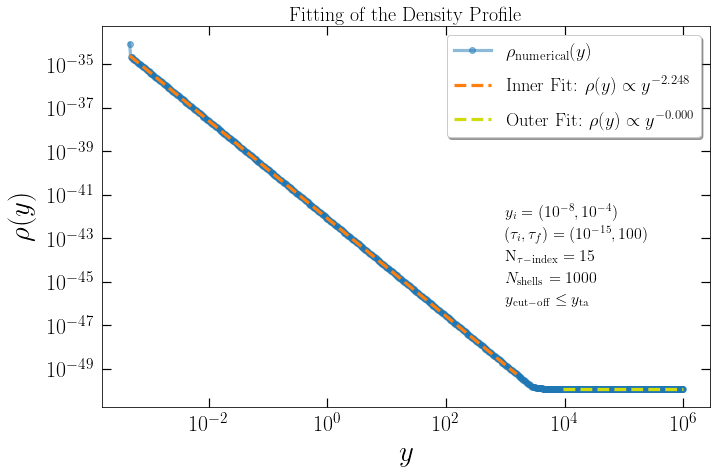

 Fitted slope (inner core):    \rho(y) \propto y^{-2.248}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}
Initial guess r_c: 3.0698636824570587


/tmp/ipykernel_10188/3191007115.py:129: RuntimeWarning: invalid value encountered in power
  return  rho_c * ((1 + r/r_c)**(-2.25))
/tmp/ipykernel_10188/3191007115.py:134: RuntimeWarning: invalid value encountered in power
  return  rho_c / (1 + (r / r_c)**(2.25))


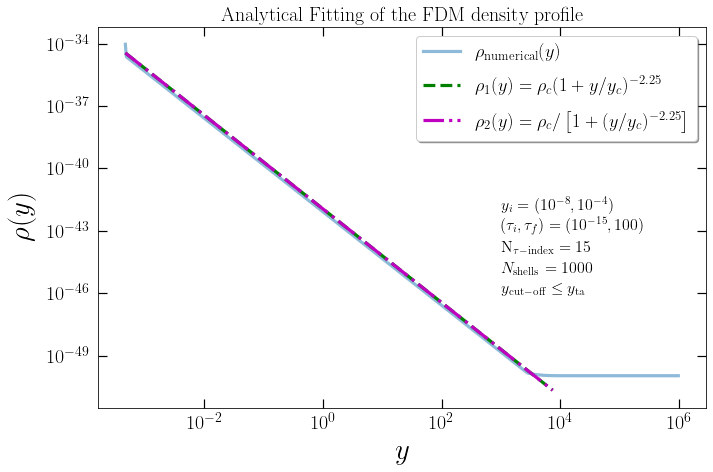

Fit 1 (rho_c, r_c): 5.9098e-24, 4.7679e-09
Fit 2 (rho_c, r_c): 6.3580e-30, 2.1423e-06
Fit 3 (rho_c, r_c): 6.3580e-30, 2.1423e-06


In [12]:
data = np.load('fdm_cdm_N1000_t15_geomspacing.npz')

r_sol = data['r_sol_fdm']
v_sol = data['v_sol_fdm']
rho_sol = data['rho_sol_fdm']
QP_arr = data['QP_arr_fdm']
cutoff_index = data['cutoff_index_fdm']
r_ta_arr = data['r_ta_arr_fdm']
t_ta_arr = data['t_ta_arr_fdm']
rho_arr = data['rho_arr_fdm']
rta_mask = data['rta_mask_fdm']
tta_mask = data['tta_mask_fdm']

r_sol_cdm = data['r_sol_cdm']
v_sol_cdm = data['v_sol_cdm']
rho_sol_cdm = data['rho_sol_cdm']
QP_arr_cdm = data['QP_arr_cdm']
cutoff_index_cdm = data['cutoff_index_cdm']
r_ta_arr_cdm = data['r_ta_arr_cdm']
t_ta_arr_cdm = data['t_ta_arr_cdm']
rho_arr_cdm = data['rho_arr_cdm']
rta_mask_cdm = data['rta_mask_cdm']
tta_mask_cdm = data['tta_mask_cdm']

data.close()  # optional, to release the file handle

###################################
# Fitting the density profile for N = 1000 evolved in the previous cell.




def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 410
outer_N = 500

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)


fig, ax = plt.subplots(figsize=(10.9, 7))
plt.rc('lines', linewidth=3.2)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')


ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')



plt.text(1000, 1e-42, '$y_i = (10^{-8}, 10^{-4})$', fontsize = 16)
plt.text(1000, 1e-43, r'$(\tau_i, \tau_f) = (10^{-15}, 100)$', fontsize = 16)
plt.text(1000, 1e-44, r'$\mathrm{N_{\tau-index}} = 15$ ', fontsize = 16)
plt.text(1000, 1e-45, r'$N_\mathrm{shells} = 1000$ ', fontsize = 16)
plt.text(1000, 1e-46, r'$y_\mathrm{cut-off} \leq  y_\mathrm{ta}$ ', fontsize = 16)






ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
plt.xlabel(r'$y$', fontsize=29, labelpad=6)
plt.ylabel(r'$\rho(y)$', fontsize=29, labelpad=11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Fitting of the Density Profile', fontsize=20)
plt.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'],  labelspacing = 0.8,
           prop = {'size':18.5},loc = 'upper right', shadow = True, 
           facecolor = 'white',fontsize = 31)
plt.savefig('fdm_N1000_rhofit_rta_t15.pdf', bbox_inches = 'tight')
plt.show()

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')






#----------------------------------------------------------------
#Analytic fitting of the FDM density profiles



# analytic guesses for FDM density profiles functions
def rho_inner_analytic1(r, rho_c, r_c):
    ratio = np.clip(r / r_c, 1e-10, None)
    return  rho_c * ((1 + r/r_c)**(-2.25))

def rho_inner_analytic2(r, rho_c, r_c):
    #if np.all(r)>r_c:
    ratio = np.clip(r / r_c, 1e-10, None)
    return  rho_c / (1 + (r / r_c)**(2.25))  
    #else: 
        #return rho_c  * (r**(-5))  # / (1 +  (r / r_c))**(2.25)
        
        

def rho_inner_analytic3(r, rho_c, r_c):
    ratio = np.clip(r / r_c, 1e-10, None)
    return  rho_c * ((1 + 1.125 * ratio**-2))**(-1.125)





final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]

mask_inner = (r_inner > 0) & (rho_inner > 0)
r_inner = r_inner[mask_inner]

rho_inner = rho_inner[mask_inner]
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

inner_N = 480
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
initial_guess = [np.max(rho_inner), np.median(r_inner)]
print("Initial guess r_c:", initial_guess[1])


popt1, _ = curve_fit(rho_inner_analytic1,r_inner,rho_inner,p0=initial_guess, maxfev=10000)
popt2, _ = curve_fit(rho_inner_analytic2,r_inner,rho_inner,p0=initial_guess,maxfev=10000)
popt3, _ = curve_fit(rho_inner_analytic3,r_inner,rho_inner,p0=initial_guess,maxfev=10000)

rho_fit1 = rho_inner_analytic1(r_inner, *popt1)
rho_fit2 = rho_inner_analytic2(r_inner, *popt2)
rho_fit3 = rho_inner_analytic2(r_inner, *popt3)




fig, ax = plt.subplots(figsize=(10.9, 7))
plt.rc('lines', linewidth=3.2)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



ax.loglog(r_valid, rho_valid,   color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit1, '--', color='g')
ax.loglog(r_inner, rho_fit2, '-.', color='m')
#ax.loglog(r_inner, rho_fit3, ':', color='r')

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
plt.xlabel(r'$y$', fontsize=29, labelpad=6)
plt.ylabel(r'$\rho(y)$', fontsize=29, labelpad=11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.set_title('Analytical Fitting of the FDM density profile', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'$ \rho_{1}(y) =  \rho_c (1 + y/y_c)^{{-2.25}}$',
           
           fr'$\rho_{2}(y) = \rho_c/ \left[1 + (y/y_c)^{{-2.25}}\right]$',
           fr'$\rho_{2}(y) = \rho_c/ \left[1 + (y/y_c)^{{-2}}\right]$'],  labelspacing = 0.8,
           prop = {'size':18.5},loc = 'upper right', shadow = True, 
          title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




plt.text(1000, 1e-42, '$y_i = (10^{-8}, 10^{-4})$', fontsize = 16)
plt.text(1000, 1e-43, r'$(\tau_i, \tau_f) = (10^{-15}, 100)$', fontsize = 16)
plt.text(1000, 1e-44, r'$\mathrm{N_{\tau-index}} = 15$ ', fontsize = 16)
plt.text(1000, 1e-45, r'$N_\mathrm{shells} = 1000$ ', fontsize = 16)
plt.text(1000, 1e-46, r'$y_\mathrm{cut-off} \leq  y_\mathrm{ta}$ ', fontsize = 16)





ax.tick_params(axis='both', labelsize=20)

plt.savefig('fdm_N1000_rhofit_analytic_rta_t15.pdf', bbox_inches = 'tight')

plt.show()

# Print fitted parameters
print(f"Fit 1 (rho_c, r_c): {popt1[0]:.4e}, {popt1[1]:.4e}")
print(f"Fit 2 (rho_c, r_c): {popt2[0]:.4e}, {popt2[1]:.4e}")
print(f"Fit 3 (rho_c, r_c): {popt2[0]:.4e}, {popt2[1]:.4e}")

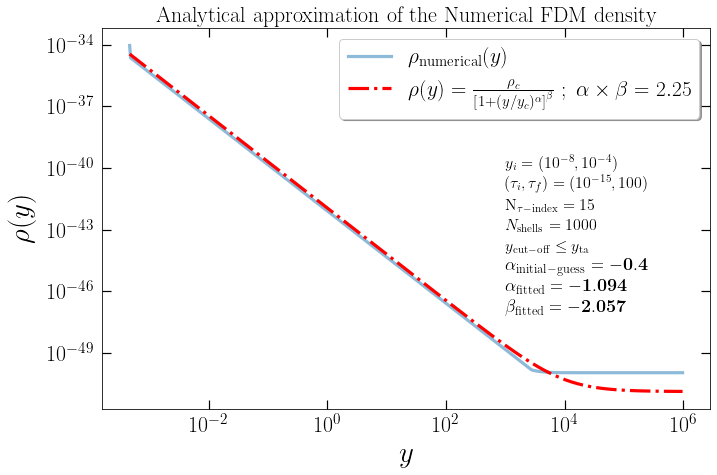

Fitted rho_c = 1.3212e-51
Fitted r_c = 9.2787e+03
Fitted alpha = -1.094
Implied beta = -2.057
Outer slope (fixed) = -2.25


In [39]:
fig, ax = plt.subplots(figsize=(10.9, 7))
plt.rc('lines', linewidth=3.2)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')


# Fitting fdm numerical density with condition that ((alpha x beta) = 2.25)
def rho_constrained(r, rho_c, r_c, alpha):
    beta = 2.25 / alpha
    ratio = np.clip(r/r_c, 1e-10, None)
    return rho_c/ ((1 + ratio**alpha)**beta)





final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]

sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Initial guess for rho_c, r_c, alpha
initial_guess = [np.max(rho_valid), np.median(r_valid), -0.4] #-0.595 gives exact fit

popt, _ = curve_fit(rho_constrained, r_valid, rho_valid, p0=initial_guess, maxfev=20000)
rho_c_fit, r_c_fit, alpha_fit = popt
beta_fit = 2.25/alpha_fit



ax.loglog(r_valid, rho_valid,   color='C0', alpha = 0.5)
ax.loglog(r_valid, rho_constrained(r_valid, *popt), 'r', ls = '-.')



plt.text(1000, 1e-40, '$y_i = (10^{-8}, 10^{-4})$', fontsize = 16)
plt.text(1000, 1e-41, r'$(\tau_i, \tau_f) = (10^{-15}, 100)$', fontsize = 16)
plt.text(1000, 1e-42, r'$\mathrm{N_{\tau-index}} = 15$ ', fontsize = 16)
plt.text(1000, 1e-43, r'$N_\mathrm{shells} = 1000$ ', fontsize = 16)
plt.text(1000, 1e-44, r'$y_\mathrm{cut-off} \leq  y_\mathrm{ta}$ ', fontsize = 16)
plt.text(1000, 1e-45, r'$\mathbf{\alpha_\mathrm{initial-guess} = -0.4}$ ', fontsize = 18)
plt.text(1000, 1e-46, r'$\mathbf{\alpha_\mathrm{fitted} = -1.094}$ ', fontsize = 18)
plt.text(1000, 1e-47, r'$\mathbf{\beta_\mathrm{fitted} = -2.057}$ ', fontsize = 18)



ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
plt.xlabel(r'$y$', fontsize=29, labelpad=6)
plt.ylabel(r'$\rho(y)$', fontsize=29, labelpad=11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.set_title('Analytical Fitting of the FDM density profile', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$',
           r'$\rho(y) = \frac{\rho_c}{\left[1 + (y/y_c)^{\alpha}\right]^{\beta}}\;;\; \alpha \times \beta = 2.25$'],
           prop = {'size':21.5},loc = 'upper right', shadow = True, 
          title_fontsize = 23,
           facecolor = 'white',fontsize = 31)


plt.title('Analytical approximation of the Numerical FDM density', fontsize = 22)


plt.savefig('fdm_N1000_rhofit_analyticfull_rta1_t15.pdf', bbox_inches = 'tight')
plt.show()

print(f"Fitted rho_c = {rho_c_fit:.4e}")
print(f"Fitted r_c = {r_c_fit:.4e}")
print(f"Fitted alpha = {alpha_fit:.3f}")
print(f"Implied beta = {beta_fit:.3f}")
print(f"Outer slope (fixed) = -2.25")


In [40]:
-1.094 * -2.057

2.2503580000000003